# Optimal network reinforcement solution for distributed generation rise.

The aim of this project is to proposed solutions for connected a generator to a grid. For this case study the network of Oberhein will be considered and the generator will be placed in the north west of it. An optimisation will be done for 2 main cases and other non optimize cases will be presented as well at the end.

In [3]:
import pandapower as pp
import pandapower.networks as pn
import pandapower.topology
import pandapower.plotting
import pandapower.converter
import pandapower.estimation
from pandapower.plotting import cmap_continuous, cmap_discrete, create_bus_collection, create_line_collection, draw_collections,create_trafo_collection
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

## Functions

In [108]:
#Initialisation
def Init(pmw_gen=10):
    net = pn.mv_oberrhein("generation")
    #Calculate the length of the lines
    for i,length in zip(net.line.index,net.line['length_km']): #consider "real" length for cost
        x1,y1 = float(net.bus_geodata['x'][net.line['from_bus'][i]]), float(net.bus_geodata['y'][net.line['from_bus'][i]])
        x2,y2 = float(net.bus_geodata['x'][net.line['to_bus'][i]]), float(net.bus_geodata['y'][net.line['to_bus'][i]])
        net.line['length_km'][i] = np.sqrt((x1-x2)**2+(y1-y2)**2)/300 #factor for convergence
    #Move position of external grid in order to be able to see the transformer on the plots
    net.bus_geodata['x'][318], net.bus_geodata['y'][318] = 3408302.042,5367780.101
    net.bus_geodata['x'][58], net.bus_geodata['y'][58] = 3420000.660 , 5369458.703
    #Creating the generator
    x_gen, y_gen = 3410832.464,5368594.558 #Determine on QGis
    pp.create_bus(net,geodata=(x_gen,y_gen),vn_kv=20.0,min_vm_pu=0.9,max_vm_pu=1.1,name='Bus 179',index=320)
    #Create generator at the created node (200)
    pp.create_gen(net,320,p_mw=pmw_gen) #Change the p_mw, max and min value?
    return net

#Technical violation functions
    #Visual plot
def Plot(net,saveName = None): #Plot map with in red the problematic(s) line(s),node(s) or transformator(s)
    # plot network with color codes
    cmap_list_node = [((0,0.9), "orangered"), ((0.9,1.1), "blue"), ((1.1,2), "red")]
    cmap_n, norm_n = cmap_discrete(cmap_list_node)
    bc = create_bus_collection(net, size=70, cmap=cmap_n, norm=norm_n);
    
    cmap_list_line = [((0, 95), "green"),((95,100),"yellow"), ((100, 200), "red")]
    cmap_l, norm_l = cmap_discrete(cmap_list_line)
    lc = create_line_collection(net, cmap=cmap_l, norm=norm_l,use_bus_geodata=True)
    
    cmap_list_trafo = [((0, 95), "lightgreen"),((95,100),"gold"), ((100, 200), "tomato")]
    cmap_t, norm_t = cmap_discrete(cmap_list_trafo)
    tc = create_trafo_collection(net,cmap=cmap_t, norm=norm_t)
    
    draw_collections([bc,tc,lc])
    plt.savefig(saveName) if saveName !=None else None

    # check constraints violation - voltage - bus
def isVoltageViolation(net):
    vMin,vMax, Node = 0.9, 1.1, [] #Init
    for k,v in enumerate(net.res_bus['vm_pu']):
        if v>vMax or v<vMin: #if violation
            Node.append(k)  #save the bus index
    return Node

    # check constraints violation - current - line
def isCurrentViolation(net):
    iMax, Line = net.line['max_i_ka'], [] #Init
    for k,i in zip(net.line.index,net.res_line['i_ka']):
        if i>iMax[k]: #if violation
            Line.append(k) #save the line index
    return Line

    # check constraints violation - load - transformer
def isTransformerViolation(net):
    loadmax, Trafo = 100, []
    for k, t in enumerate(net.res_trafo['loading_percent']):
        if t>loadmax: #if violation
            Trafo.append(k) #save the trafo index
    return Trafo
    
    #Return boolean of "is there violation?" with the value of bus, line and transfo that the limiting factor.
def isThereViolation(net,plot=False,saveName=None):
    if plot:
        Plot(net,saveName)
    N,L,T = isVoltageViolation(net),  isCurrentViolation(net),  isTransformerViolation(net)
    if N!=[] or L!=[] or T!=[]:
        return [True, N, L , T]
    return [False, N, L, T]

#Function of connexion

    #Connect the generator to the network at bus "node". plot the line
def ConnexionGen(net, node, plot=True,saveName=None):
    x_nod = float(net.bus_geodata['x'][net.bus_geodata.index==node])
    y_nod = float(net.bus_geodata['y'][net.bus_geodata.index==node])
    x_gen, y_gen = 3410832.464,5368594.558 #Determine on QGis
    len_con = np.sqrt((x_gen-x_nod)**2+(y_gen-y_nod)**2)/300 #factor for convergence
    if net.bus.vn_kv[node] == net.bus.vn_kv[320]:
        pp.create_line(net,320,node,length_km=len_con,std_type="243-AL1/39-ST1A 20.0") #generator at bus 320
        T = False
    else:
        pp.create_bus(net,geodata=(x_gen+0.1,y_gen+0.1),vn_kv=110.0,min_vm_pu=0.9,max_vm_pu=1.1,name='Bus 180',index=321)
        pp.create_transformer(net,321,320,std_type="63 MVA 110/20 kV")
        pp.create_line(net,321,node,length_km=len_con,std_type="149-AL1/24-ST1A 110.0") #generator at bus 320
        T = True #say if a transformer was needed or not
    pp.runpp(net)
    return isThereViolation(net,plot=plot,saveName=saveName),len_con,T
    

    #Change the problematic component (for now just lines)
def ChangeComp(net,id_node,id_line,id_trafo, pmw_gen=10,plot=True,saveName=None):
    net.gen.p_mw[0] = pmw_gen
    LengthSout, LengthAer,Ori,TCh = 0,0,False, 0
    for l in id_line:
        Origin = False #set for each line that it is not the connexion line
        if net.line.from_bus[l] == 320:
            Origin,Ori = True, True #set for this line Origin -> not consider the length as changed + say that it has been changed (change cost)
        fromb,tob,lenb,std_type = net.line['from_bus'][l],net.line['to_bus'][l],net.line['length_km'][l], net.line['std_type'][l] #extract data
        net.line = net.line.drop(l) #drop the problematic line
        if std_type == 'NA2XS2Y 1x185 RM/25 12/20 kV' or std_type=='N2XS(FL)2Y 1x300 RM/35 64/110 kV': 
            #distinction between underground and overhead cable
            pp.create_line(net,fromb,tob,length_km=lenb,std_type="N2XS(FL)2Y 1x300 RM/35 64/110 kV",index=l) #replace it
            LengthSout+=lenb*(1-Origin)
        else:
            pp.create_line(net,fromb,tob,length_km=lenb,std_type="490-AL1/64-ST1A 380.0",index=l) #replace it
            LengthAer += lenb*(1-Origin)
    Tr = [114,142,143]
    for t in id_trafo:
        fromb,tob = net.trafo['hv_bus'][Tr[t]],net.trafo['lv_bus'][Tr[t]] #extract data
        net.trafo = net.trafo.drop(Tr[t]) #drop the problematic trafo
        pp.create_transformer(net,fromb,tob,std_type="63 MVA 110/20 kV",index=Tr[t]) #replace it
        TCh+=1
    # for nodes: analyse the lines around the nodes to change them
    pp.runpp(net)
    return isThereViolation(net,plot=plot,saveName=saveName), [LengthAer,LengthSout], Ori,TCh

def CreateLine20kV(net,nod1,nod2,plot=True,saveName=None): #Create a line between 2 nodes
    x1,y1 = float(net.bus_geodata['x'][net.bus_geodata.index==nod1]), float(net.bus_geodata['y'][net.bus_geodata.index==nod1])
    x2,y2 = float(net.bus_geodata['x'][net.bus_geodata.index==nod2]), float(net.bus_geodata['y'][net.bus_geodata.index==nod2])
    len_con = np.sqrt((x2-x1)**2+(y2-y1)**2)/300 #factor for convergence
    pp.create_line(net,nod1,nod2,length_km=len_con,std_type="243-AL1/39-ST1A 20.0")
    pp.runpp(net)
    return isThereViolation(net,plot=plot,saveName=saveName),len_con

def DoubleCon(net,node1,node2,plot=True,saveName=None): #Connect the generator to node1 and node2
    _,lent1,T1 = ConnexionGen(net,node1,plot=False)
    PB,lent2,T2 = ConnexionGen(net,node2,plot=plot,saveName=saveName)
    return PB,[lent1,lent2],np.max([T1,T2])

#Cost function
#Initial fixed cost
#Rigth of Way
LandWidth = 0.024384 #km
LandCost = 70 #€/m2
#Line
PriceL = 3.6*3#€/m #243mm2
PriceL2 = 7.2*3 #€/m #changed by 490mm2
PriceL3 = 4.4*3 #€/km (underground)
#Structure
DistTower = 107.3 #m (distance between each pillar)
CostTower = 21003.58 #€/tower
#T&GU
CostDef = 256 #€/0.004km2 (deforestation of ligth vegetation)
#Trafo
PriceTr = 623889 #€
    #return initial cost in function of length
def Cost(length,lengthChangAer=0,lengthChangSout=0,Origin=False,Tch=0):
    LandRow = LandCost*LandWidth*length*1e6
    if Origin: #If changing the origin line ( connected to the generator)
        Line = [PriceL2*length*1e3, PriceL2*lengthChangAer*1e3, PriceL3*lengthChangSout*1e3] #use the price corresponding for it
    else:
        Line = [PriceL*length*1e3, PriceL2*lengthChangAer*1e3, PriceL3*lengthChangSout*1e3] #consider the price of the changed line
    Structure = CostTower*np.ceil(length*1e3/DistTower)
    TGU = CostDef*(LandWidth*length)/0.004
    return (LandRow+Line[0]+Structure+TGU)+Line[1]+Tch*PriceTr+Line[2]

#"Optimisation" functions

    #return max power of the added generator for the given network organisation
def MaxPow(net, p_min = 0, p_max = 30,N=100): 
    i=0
    while i<N:
        p_mw = (p_min+p_max)/2
        net.gen['p_mw'][0] = p_mw
        pp.runpp(net)
        if not isThereViolation(net)[0]:
            p_min = p_mw
        else:
            p_max = p_mw
        i+=1
    return net.gen['p_mw'][0]

    #Function to calculate the max power achievable for all node connexions
def ScatterPlotCase1(net,p_max=20,save=True):
    MAX,COST = [],[]
    for j,i in enumerate(net.bus.index[:179]): #avoid doing the calculation with gen connected to himself
        net = Init()
        _,lenl,T = ConnexionGen(net,i,plot=False)
        COST.append(Cost(lenl))
        if T:
            COST[j] +=PriceTr #if transformer add its price)
        MAX.append(MaxPow(net,p_max=p_max))
        if j%int(len(net.bus.index)/4)==0: #plot the advancement of the function every 25%
            print(f'{j/len(net.bus.index)*100}%')
    while [i for i,maxi in enumerate(MAX) if maxi==p_max]!=[]: #divide loop to avoid divergence for low gen capacity node connexions
        for i in [i for i,maxi in enumerate(MAX) if maxi==p_max]:
            net = Init()
            node = net.bus.index[i]
            ConnexionGen(net,node,plot=False)
            MAX[i] = MaxPow(net,p_max=p_max+10)
        p_max+=10
    #Create pandas + Plot
    Datas = pd.DataFrame(index = net.bus.index[:179])
    Datas["Max Power [MW]"] = MAX
    Datas["Price [M€]"] = 1e-6*np.array(COST)
    sns.lmplot(x = 'Max Power [MW]', y = 'Price [M€]', data = Datas, fit_reg=False)
    if save:
        plt.savefig("Case1Scatter.png")
        Datas.to_excel('Case1Scatter.xlsx')
    return Datas

def ScatterPlotCase2(net,save=True,eps = 0.01): #Change the lines that were problematic in case 1
    MAX,COST = [],[]
    Case1Pow = pd.read_excel('Case1Scatter.xlsx') #take the violation power value from case 1
    for j,i in enumerate(net.bus.index[:179]): #avoid doing the calculation with gen connected to himself
        p_max = Case1Pow['Max Power [MW]'][j]+eps
        net = Init(pmw_gen=p_max) #max power achievable for Case1
        PB,lenl,T = ConnexionGen(net,i,plot=False)
        _, LENT,Origin,Tch = ChangeComp(net,PB[1],PB[2],PB[3],pmw_gen=p_max,plot=False,saveName=None)
        COST.append(Cost(lenl,LENT[0],LENT[1],Origin,Tch))
        if T:
            COST[j] +=PriceTr #if transformer add its price)
        MAX.append(MaxPow(net,p_max=p_max))
        if j%int(len(net.bus.index)/4)==0: #plot the advancement of the function every 25%
            print(f'{j/len(net.bus.index)*100}%')
    c=0
    while [i for i,maxi in enumerate(MAX) if maxi==Case1Pow['Max Power [MW]'][i]+eps+c]!=[]: #divide loop to avoid divergence
        for i in [i for i,maxi in enumerate(MAX) if maxi==Case1Pow['Max Power [MW]'][i]+eps+c]: #search new max
            p_max = Case1Pow['Max Power [MW]'][i]+eps
            net = Init(pmw_gen=p_max)
            node = net.bus.index[i]
            PB,_,_ = ConnexionGen(net,node,plot=False)
            PB,_,_,_ = ChangeComp(net,PB[1],PB[2],PB[3],pmw_gen=p_max,plot=False,saveName=None)
            MAX[i] = MaxPow(net,p_max=p_max+(c+10)) #search the new max
        c+=10 #increase 10MW the search limit
    #Create pandas + Plot
    Datas2 = pd.DataFrame(index = net.bus.index[:179])
    Datas2["Max Power [MW]"] = MAX
    Datas2["Price [M€]"] = 1e-6*np.array(COST)
    sns.lmplot(x = 'Max Power [MW]', y = 'Price [M€]', data = Datas2, fit_reg=False)
    if save:
        plt.savefig("Case2Scatter.png")
        Datas2.to_excel('Case2Scatter.xlsx')
    return Datas2

def ScatterPlotCase2MAX(net,save=True,eps = 0.01): #Change the line that were problematic in case 1
    MAX,COST = [],[]
    Case1Pow = pd.read_excel('Case1Scatter.xlsx') #take the violation power value from case 1
    for j,i in enumerate(net.bus.index[:179]): #avoid doing the calculation with gen connected to himself
        PB, PBnew = [[],[],[]],[[],[],[]] #Initialise the Pbs
        p_max = Case1Pow['Max Power [MW]'][j]+eps
        net = Init(pmw_gen=p_max) #max power achievable for Case1
        PBnew,lenl,T = ConnexionGen(net,i,plot=False)
        LENTCH,Tchtot,Oritot = [0,0],0,False
        while [i for i in PBnew[2] if i in PB[2]]==[] and [i for i in PBnew[1] if i in PB[1]]==[]: 
        #Change until there is a pb line after changing that was also the pb line before the change
            PB = PBnew #PB is the old PB and PB2 the new
            PBnew, LENT,Origin,Tch = ChangeComp(net,PB[1],PB[2],PB[3],pmw_gen=p_max,plot=False,saveName=None)
            LENTCH, Tchtot = [LENTCH[0]+LENT[0],LENTCH[1]+LENT[1]], Tchtot+Tch
            if Origin:
                Oritot=True
            p_max+=0.5 #Add 1MW to the limit caclulation of the max (1 because of convergence pb)
        COST.append(Cost(lenl,LENTCH[0],LENTCH[1],Origin,Tch))
        if T:
            COST[j] +=PriceTr #if transformer at the connexion add its price)
        MAX.append(MaxPow(net,p_max=p_max))
        if j%int(len(net.bus.index)/4)==0: #plot the advancement of the function every 25%
            print(f'{j/len(net.bus.index)*100}%')
    #Create pandas + Plot
    Datas2 = pd.DataFrame(index = net.bus.index[:179])
    Datas2["Max Power [MW]"] = MAX
    Datas2["Price [M€]"] = 1e-6*np.array(COST)
    sns.lmplot(x = 'Max Power [MW]', y = 'Price [M€]', data = Datas2, fit_reg=False)
    if save:
        plt.savefig("Case2ScatterMAX.png")
        Datas2.to_excel('Case2ScatterMAX.xlsx')
    return Datas2

 ## Presentation of the network and connexion examples
 
Oberrhein network in “generation” scenario in which the position of the 2 external grids are moved a bit (hv and lv bus were at the same location) for better visibility of the transformer. The network is a distribution grid. A generator is put in the north east of the network at 20kV. 

This pandapower network includes the following parameter tables:
   - bus (180 elements)
   - load (147 elements)
   - sgen (153 elements)
   - gen (1 element)
   - switch (322 elements)
   - ext_grid (2 elements)
   - line (181 elements)
   - trafo (2 elements)
   - line_geodata (181 elements)
   - bus_geodata (180 elements)
 and the following results tables:
   - res_bus (180 elements)
   - res_line (181 elements)
   - res_trafo (2 elements)
   - res_ext_grid (2 elements)
   - res_load (147 elements)
   - res_sgen (153 elements)
   - res_gen (1 element)
   - res_switch (322 elements)


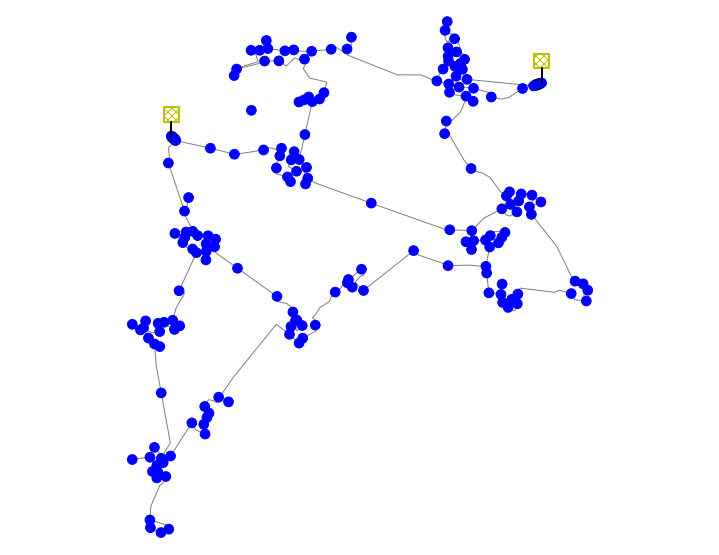

In [14]:
network = Init()
pp.runpp(network)
print(network)
#pandapower.to_excel(network, "AC_datas.xlsx")
pandapower.plotting.simple_plot(network);

Length = 4.369061502644277km; Pb_bus=[] ; Pb_line=[52, 53, 62, 194] ; Pb_trafo=[1] ; Transfo installed? = False
Max gen power = 18.669537000667923


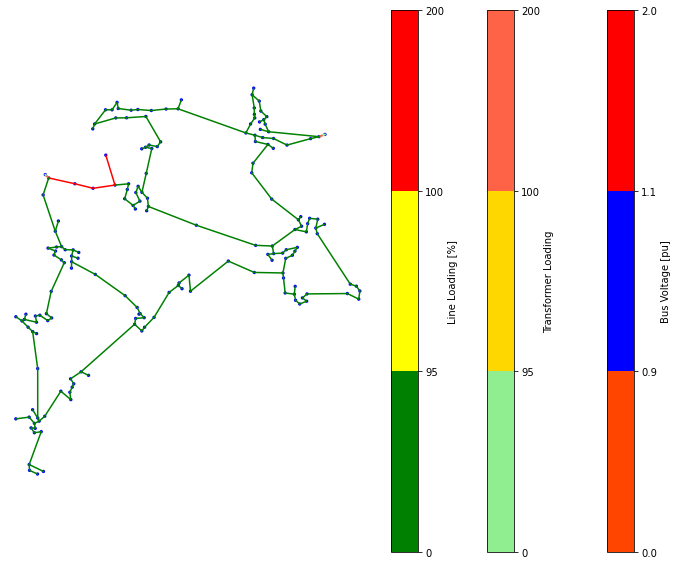

In [105]:
# Exemple with problem
p_max = 30
network = Init(pmw_gen = p_max)
PB,length,T = ConnexionGen(network,30,plot=True)
print(f'Length = {length}km; Pb_bus={PB[1]} ; Pb_line={PB[2]} ; Pb_trafo={PB[3]} ; Transfo installed? = {T}' )
maxg = MaxPow(network,p_max=p_max+15); print(f'Max gen power = {maxg}')

Length changed [9.43974853636308, 0]; Pb_bus=[] ; Pb_line=[] ; Pb_trafo=[]
Max gen power = 29.699772248656764


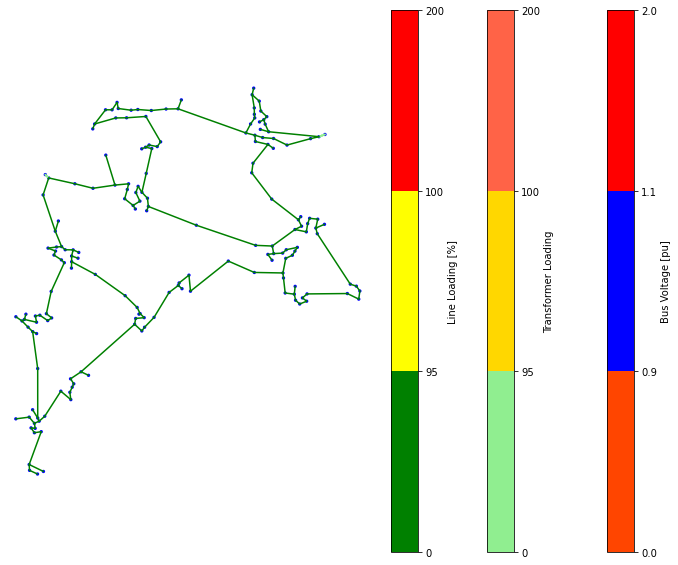

In [106]:
#Exemple of change component
PB,lent,_,_ = ChangeComp(network,PB[1],PB[2],PB[3],pmw_gen=17)
print(f'Length changed {lent}; Pb_bus={PB[1]} ; Pb_line={PB[2]} ; Pb_trafo={PB[3]}')
maxg = MaxPow(network,p_max = p_max+10); print(f'Max gen power = {maxg}')

## Optimisation

An optimisation is proposed through a scatter plot of the capital cost in function of the maximum power that the generator can give for each nodes. Therefore each point represent a scenario of connexion.

This work will be done considering three cases: 
- **Case 1** : The generator is connected to a node with the same overhead cable already used in the network.
- **Case 2.1** : The generator is connected to a node a the problematic line at maxPower+0.01 is changed.
- **Case 2.2** : The generator is connected to a node and all the line that allows to increase the maximum power are changed.

Noted that when changing line, the strongest line is directly considered to avoid changing again the line in the future when other generator are going to come (and for simplification).

0.0%
25.0%
50.0%
75.0%


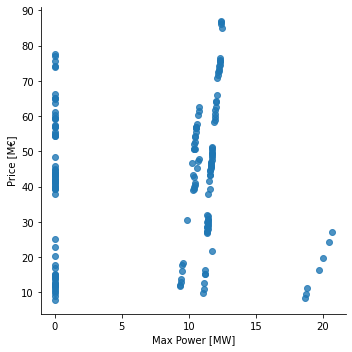

In [11]:
OptiScatter = ScatterPlotCase1(network) #Case1

0.0%
25.0%
50.0%
75.0%


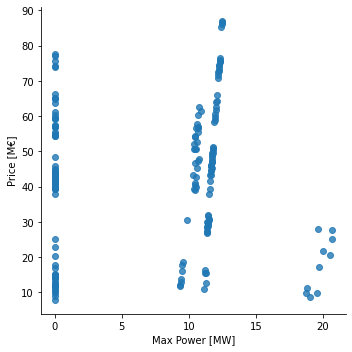

In [12]:
OptiScatter2 = ScatterPlotCase2(network) #Case2.1

0.0%
25.0%
50.0%
75.0%


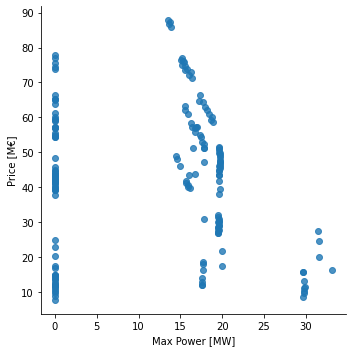

In [18]:
OptiScatter2Max = ScatterPlotCase2MAX(network) #Case2.2

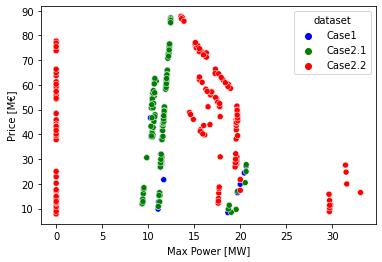

In [182]:
#Resumed all cases in the same plot
OptiScatter = pd.read_excel("Case1Scatter.xlsx")
OptiScatter2 = pd.read_excel("Case2Scatter.xlsx")
OptiScatter2Max = pd.read_excel("Case2ScatterMAX.xlsx")
concatenated = pd.concat([OptiScatter.assign(dataset='Case1'),OptiScatter2.assign(dataset='Case2.1'),OptiScatter2Max.assign(dataset='Case2.2')])
sns.scatterplot(x='Max Power [MW]', y='Price [M€]', data=concatenated, hue='dataset',palette = {'Case1':'blue',"Case2.1":'green',"Case2.2":'red'});
#plt.savefig("resumedCases.png")

## Extra Cases

Other connexion scenario can be think of but for reasons of time all the possible combination will not be tested in this project.
Therefore they still can be compared, the two other cases that we can think of are:
- **Case1Extra** : Connect the generator to 2 different nodes.
- **Case2Extra** : Connect the generator to a node and create a connexion elswhere in the circuit.

Length = 8.860885146991015km and 4.369061502644277km ; Pb_bus=[] ; Pb_line=[] ; Pb_trafo=[] ; Transfo installed? = True
Max gen power = 29.699772248656764
Cost of this configuration is 25.97379401836825M€


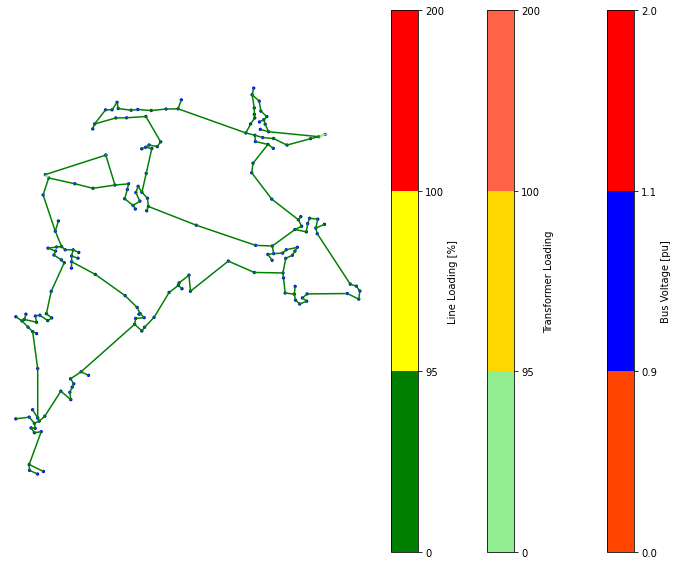

In [197]:
#Exemple DoubleConnexion
network = Init(pmw_gen = 60)
pp.runpp(network)
PB,LENGTH, T = DoubleCon(network,318,30)
print(f'Length = {LENGTH[0]}km and {LENGTH[1]}km ; Pb_bus={PB[1]} ; Pb_line={PB[2]} ; Pb_trafo={PB[3]} ; Transfo installed? = {T}' )
maxgDouble = MaxPow(network,p_max=70); print(f'Max gen power = {maxg}')
CoutDouble = Cost(sum(LENGTH),Tch=1); print(f'Cost of this configuration is {CoutDouble*1e-6}M€')

Length = 8.860885146991015km and 7.0372062932060695 km; Pb_bus=[] ; Pb_line=[] ; Pb_trafo=[] ; Transfo installed? = True
Max gen power = 62.977217232293626
Cost of this configuration is 31.086066304945103M€


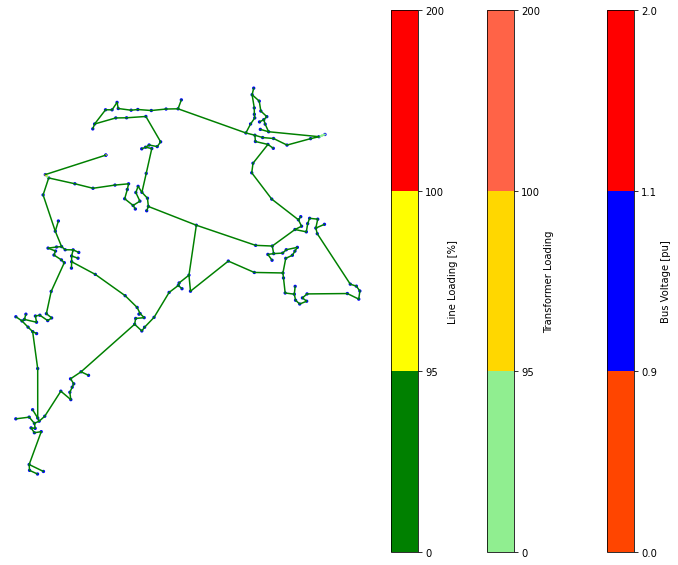

In [198]:
#Exemple other line in network
network = Init(pmw_gen=60)
pp.runpp(network)
_,length,T = ConnexionGen(network,318,plot=False)
PB,length2 = CreateLine20kV(network,136,33,plot=True)
print(f'Length = {length}km and {length2} km; Pb_bus={PB[1]} ; Pb_line={PB[2]} ; Pb_trafo={PB[3]} ; Transfo installed? = {T}' )
maxgElsewhere = MaxPow(network,p_max=70); print(f'Max gen power = {maxgElsewhere}')
CoutElsewhere = Cost(length+length2,Tch=1); print(f'Cost of this configuration is {CoutElsewhere*1e-6}M€')

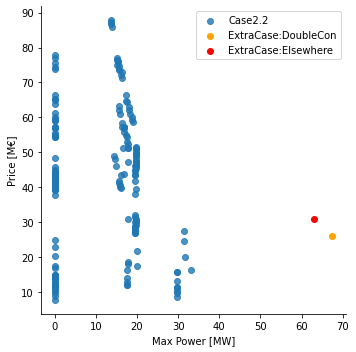

In [196]:
#Plot them on the ScatterPlot of Case2.2:
OptiScatter2Max = pd.read_excel("Case2ScatterMAX.xlsx")
OptiScatter2Max['dataset']='Case2.2'
sns.lmplot(x = 'Max Power [MW]', y = 'Price [M€]', data = OptiScatter2Max, fit_reg=False,hue='dataset',legend=False)
plt.scatter(x=maxgDouble, y = CoutDouble*1e-6,color='orange',label='ExtraCase:DoubleCon')
plt.scatter(x=maxgElsewhere, y = CoutElsewhere*1e-6,color='r',label='ExtraCase:Elsewhere')
plt.legend();
#plt.savefig("ExtraCases.png")

## Appendix

In [94]:
#Organized geodata same way as bus sheet
# GeoData = pd.DataFrame(index = network.bus.index)
# X,Y = [],[]
# for idx in network.bus.index:
#     X.append(network.bus_geodata.loc[idx][0])
#     Y.append(network.bus_geodata.loc[idx][1])
# GeoData['x'] = X
# GeoData['y'] = Y
# GeoData.to_excel('GeoDataOrdonnée.xlsx')